# Neural Networks: Dataset

Creation of training, validation and tests dataset to have comparable results when running the models.

## Imports and function definitions

In [6]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from imblearn.under_sampling import CondensedNearestNeighbour, RandomUnderSampler
from keras.utils import to_categorical
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
# One Hot encoding
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

In [8]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [9]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_space(X, y, title):  
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig, elev=20, azim=134)
    
    for l, c, m in zip(np.unique(y), colors, markers):
        ax.scatter(
            X[y==l, 0],
            X[y==l, 0],
            X[y==l, 0],
            c=c, label=l, marker=m, edgecolor='k'
        )

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.dist = 12
    ax.set_title(title)
    ax.legend(loc='upper right')

## Data loading

In [10]:
# When using Goolge Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
base_path = "/content/drive/My Drive"

In [12]:
full_filepath = f"{base_path}/datasets/neural_networks/zenodo_open_metadata_2020-11-26_balanced_text_4000_lang_en.jsonl"
full_df = pd.read_json(full_filepath, lines=True)  # The file is JSONLines

In [13]:
full_df.head()

,recid,text_4000,spam,lang
0,1835666,the etiology of acute pleurisy with effusion n/a,False,en
1,3044415,biodiversity taxonomy terrestrial herbarium so...,False,en
2,2825828,science school was burned: a case study of cri...,False,en
3,1683734,the heat of vaporization of air n/a,False,en
4,3788697,biodiversity taxonomy animalia arthropoda inse...,False,en


In [14]:
# Split dataset

labels = full_df['spam']
cat_labels = to_categorical(labels)
data = full_df["text_4000"]

In [15]:
data.head()

0     the etiology of acute pleurisy with effusion n/a
1    biodiversity taxonomy terrestrial herbarium so...
2    science school was burned: a case study of cri...
3                  the heat of vaporization of air n/a
4    biodiversity taxonomy animalia arthropoda inse...
Name: text_4000, dtype: object

In [16]:
spam_ham = full_df.spam.value_counts()
print(spam_ham)

False    31018
True     25172
Name: spam, dtype: int64


## Stopwords removal

Only possible when treating the English only dataset

In [19]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stopwords = set(stopwords.words('english'))

def remove_stopwords(text):
    text_array = text.split(' ')  # Assumes it was preprocessed to be punctuationless
    diff = set(text_array).difference(set(stopwords))  # Not perfect but good enough

    return ' '.join(diff)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
full_df['text_stop'] = full_df.apply(lambda x: remove_stopwords(x['text_4000']), axis=1)

In [21]:
data = full_df["text_stop"]
data.head()

0                 effusion acute pleurisy etiology n/a
1    physalodes botanic meise (br0000014444050) her...
2    thailand (4.4 crisis. denial, usd). education ...
3                            vaporization heat air n/a
4     catocala female (coll. jessica. states edward...
Name: text_stop, dtype: object

## One Hot vectorization

One hot encoding allows to have each term identified in a vocabulary, which is needed for the input of the `Embedding` layerd. In addition, TF-IDF can camuflage different words with a similar score and we want the Embedding to find this out.

In [23]:
vocab_size = 150000  # To account for different languages
max_input_length = 4000 # We assume that there cannot be more than 4000k words 

In [24]:
data_vec = []
max_length = -1
safeguard = 4000

for record in data:
    # filters and lower should not be needed. Those were applied on preprocessing (notebook 0)
    vec = one_hot(record, vocab_size, split=' ')
    vec_len = len(vec)
    if vec_len > max_length:
      max_length = vec_len

    # This should never happen, it is just a safeguard
    if vec_len > safeguard:
      if len(record.split(' ')) > safeguard:  # This should never be True. It is a safeguard.
        print(f"Hard failure. input len {len(record)}")
      print(f"Soft failure. One hot expanded, found length {vec_len}")
    
    data_vec.append(vec)
    
print(f"Maximum length {max_length}")

Maximum length 1528


In [25]:
data_vec_padded = pad_sequences(data_vec, maxlen=max_length)

### Display the distribution in 2D and 3D using PCA

In [26]:
pca_2 = PCA(n_components=2)

# y = labels (no need to assign)
# If using TF-IDF the data_vec needs to be made dense (it is a sparse one), use `.todense()`
X_2d = pca_2.fit_transform(data_vec_padded)

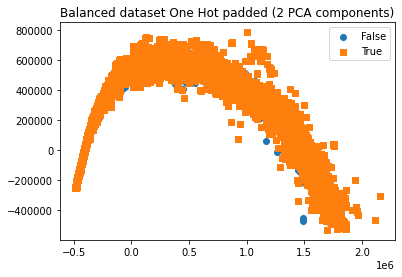

In [27]:
plot_2d_space(X_2d, labels, 'Balanced dataset One Hot padded (2 PCA components)')

In [28]:
pca_3 = PCA(n_components=3)

# y = labels (no need to assign)
# If using TF-IDF the data_vec needs to be made dense (it is a sparse one), use `.todense()`
X_3d = pca_3.fit_transform(data_vec_padded)

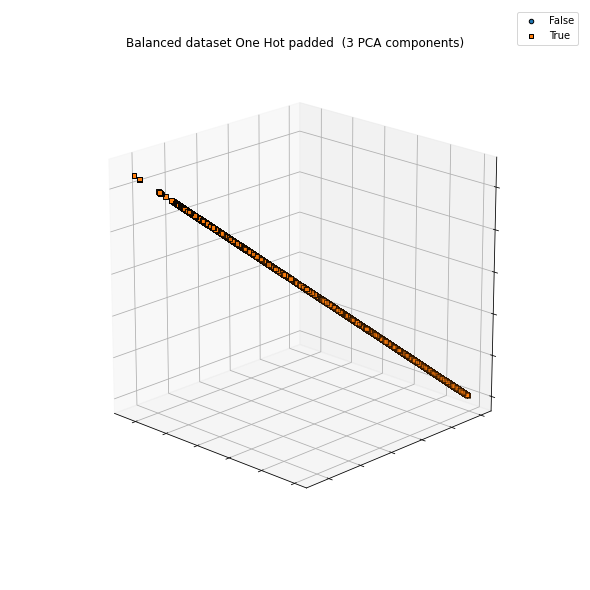

In [29]:
plot_3d_space(X_3d, labels, 'Balanced dataset One Hot padded  (3 PCA components)')

## Dataset split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(data_vec_padded, cat_labels, test_size=0.3, random_state=422)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=422)

In [31]:
print(f"Training set shape {X_train.shape}")
print(f"Validation set shape {X_val.shape}")
print(f"Test set shape {X_test.shape}")

Training set shape (35399, 1528)
Validation set shape (3934, 1528)
Test set shape (16857, 1528)


In [32]:
num_classes = 2  # Number of target classes (Spam and Ham)

In [33]:
print(f"Training labels set size {y_train.shape}")
print(f"Validation labels set size {y_val.shape}")
print(f"Test labels set size {y_test.shape}")

Training labels set size (35399, 2)
Validation labels set size (3934, 2)
Test labels set size (16857, 2)


In [34]:
pickle.dump(X_train, open(f"{base_path}/datasets/neural_networks/zenodo_open_metadata_2020-11-26_X_train_en.pkl","wb"))
pickle.dump(X_val, open(f"{base_path}/datasets/neural_networks/zenodo_open_metadata_2020-11-26_X_val_en.pkl","wb"))
pickle.dump(X_test, open(f"{base_path}/datasets/neural_networks/zenodo_open_metadata_2020-11-26_X_test_en.pkl","wb"))

pickle.dump(y_train, open(f"{base_path}/datasets/neural_networks/zenodo_open_metadata_2020-11-26_y_train_en.pkl","wb"))
pickle.dump(y_val, open(f"{base_path}/datasets/neural_networks/zenodo_open_metadata_2020-11-26_y_val_en.pkl","wb"))
pickle.dump(y_test, open(f"{base_path}/datasets/neural_networks/zenodo_open_metadata_2020-11-26_y_test_en.pkl","wb"))